In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
from model_kit import datafiles as dfx
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

Last date this notebook was ran: 2021-11-10


In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
psd_dir = home_dir + 'PSD/model_parameters/'
psf_mask_dir = data_dir + 'mask_psf/'

vAPP_dir = data_dir+'data/coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# open all the masks
top_circ = fits.open(psf_mask_dir + 'psf_top_circle_{0}.fits'.format(fr_parm['npix']))[0].data
bot_circ = fits.open(psf_mask_dir + 'psf_bot_circle_{0}.fits'.format(fr_parm['npix']))[0].data
top_dhmask = fits.open(psf_mask_dir + 'psf_top_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
bot_dhmask = fits.open(psf_mask_dir + 'psf_bot_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

In [3]:
# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# acquiring csv numerical values for specifically named optics
optic_name = []
optic_num = []
for t_optic, test_opt in enumerate(rx_difflim):        
    # Building the optic name and number list
    if (test_opt['Type'] == 'mirror' or test_opt['Type']=='DM'):
        optic_name.append(rx_difflim[t_optic]['Name'])
        optic_num.append(rx_difflim[t_optic]['Optical_Element_Number'])
optic_name.append('None')
optic_num.append(35)

# remove all values except the last 8 values
optic_name = optic_name[(len(optic_name)-8):]
optic_num = optic_num[(len(optic_num)-8):]

### Data Processing
Skip these 2 cells if the folder isn't available locally

In [21]:
# now get all the psd switch data
tot_opt = len(optic_num) # last one is for noneRemoved, calculated separately
tot_sets = 5
tot_n = 1

top_switch = np.zeros((tot_opt, tot_sets))
bot_switch = np.zeros((tot_opt, tot_sets))

fr_parm['wfe_data'] = 'allopd'
vapp_name = ['leak', 'pos', 'neg']

# initialize the folder
fr_folder = 'n0_{0}_{1}_tol_psdswitch_all_cal/'.format(fr_parm['wfe_data'], fr_parm['npix'])

for ind in range(0, tot_opt): # chooses tested optic (row)
    ji = optic_num[ind]
    
    for si in range(0, tot_sets): # chooses test set number (col)
        # build the psf
        loc_base = 'psf_mwfs_{0}_s{1}_j{2}_{3}nm_'.format(fr_parm['wfe_data'], si,
                                                          ji, wavelen_str)
        psf_tot = np.zeros((fr_parm['npix'], fr_parm['npix']))
        for j_v in range(0, len(vapp_name)):
            psf_data = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].data
            if vapp_name[j_v] == 'leak':
                psf_data *= fr_parm['leak_mult']
            psf_tot += psf_data

        # save the total PSF
        hdr = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].header
        hdr['vapp_psf'] = ('total', 'vapp piece or full psf')
        hdr['leak_val'] = (fr_parm['leak_mult'], 'leak (0) phase psf multiplier')
        fits.writeto(fr_folder+loc_base+'tot.fits', psf_tot, hdr, overwrite=True)

        # top psf
        psf_top_circ = psf_tot * top_circ
        psf_top_circ /= np.amax(psf_top_circ) # normalize to region
        top_switch[ind][si] = rms(psf_top_circ[top_dhmask==1])

        # bottom psf
        psf_bot_circ = psf_tot * bot_circ
        psf_bot_circ /= np.amax(psf_bot_circ) # normalize to region
        bot_switch[ind][si] = rms(psf_bot_circ[bot_dhmask==1])

# get the average line and standard dev bar
top_switch_avg = np.mean(top_switch, axis=1)
top_switch_std = np.std(top_switch, axis=1)
bot_switch_avg = np.mean(bot_switch, axis=1)
bot_switch_std = np.std(bot_switch, axis=1)

In [23]:
# Save the data
# write fits header
hdr = fits.Header()
hdr['comment'] = 'allopd, closed loop data'
hdr['comment'] = 'closed loop results only'
hdr['comment'] = 'psd set: calibrated switch psd'
hdr['comment'] = 'rows: different optical surfaces'
hdr['comment'] = 'last row is noneRemoved'
hdr['comment'] = 'columns: different set psd sets'
hdr['comment'] = 'only the downstream coronagraph optics'

fits.writeto('data_reduce/fresnelmetric_tol_{0}_dhtop_psdswitch.fits'.format(fr_parm['wfe_data']),
             top_switch, hdr, overwrite=True)
fits.writeto('data_reduce/fresnelmetric_tol_{0}_dhbot_psdswitch.fits'.format(fr_parm['wfe_data']),
             bot_switch, hdr, overwrite=True)

### Plot Generating
Only works if the data metrics fits files are available.

In [8]:
# Open up the original comparison data
tot_opt = len(optic_num) # last one is for noneRemoved, calculated separately
tot_sets = 5

# load up the original data
dhtop_data = fits.open('data_reduce/fresnelmetric_tol_{0}_dhtop_calpsd.fits'.format(fr_parm['wfe_data']))[0].data
dhbot_data = fits.open('data_reduce/fresnelmetric_tol_{0}_dhbot_calpsd.fits'.format(fr_parm['wfe_data']))[0].data

# separate out the parts that matter
top_orig = dhtop_data[-tot_opt:,0:tot_sets]
bot_orig = dhbot_data[-tot_opt:,0:tot_sets]

# get the average line and standard dev bar
top_orig_avg = np.mean(top_orig, axis=1)
top_orig_std = np.std(top_orig, axis=1)
bot_orig_avg = np.mean(bot_orig, axis=1)
bot_orig_std = np.std(bot_orig, axis=1)

######################################
# Open up the psd switch comparison data
top_switch = fits.open('data_reduce/fresnelmetric_tol_{0}_dhtop_psdswitch.fits'.format(fr_parm['wfe_data']))[0].data
bot_switch = fits.open('data_reduce/fresnelmetric_tol_{0}_dhbot_psdswitch.fits'.format(fr_parm['wfe_data']))[0].data

# get the average line and standard dev bar
top_switch_avg = np.mean(top_switch, axis=1)
top_switch_std = np.std(top_switch, axis=1)
bot_switch_avg = np.mean(bot_switch, axis=1)
bot_switch_std = np.std(bot_switch, axis=1)

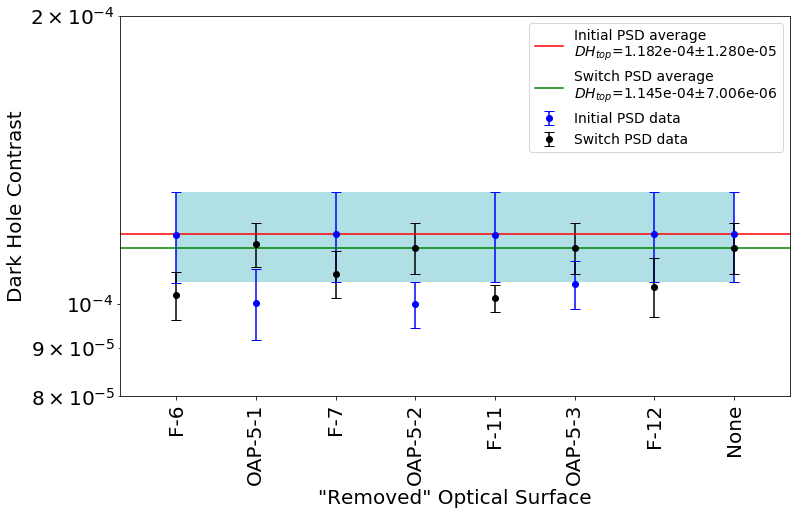

In [9]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
# individual dots and error bar lines - original data
plt.errorbar(optic_name,top_orig_avg, yerr=top_orig_std, fmt='o', color='b',
             capsize=5, label='Initial PSD data')
# original data horz line
plt.axhline(top_orig_avg[-1], color='r', 
            label='Initial PSD average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                        top_orig_avg[-1],
                                                                        top_orig_std[-1]))
# original data std dev region
plt.fill_between(np.arange(len(optic_name)),
                 top_orig_avg[-1]+top_orig_std[-1],
                 top_orig_avg[-1]-top_orig_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
# individual dots and error bar lines - original data
plt.errorbar(optic_name,top_switch_avg, yerr=top_switch_std, fmt='o', color='k',
             capsize=5, label='Switch PSD data')
# original data horz line
plt.axhline(top_switch_avg[-1], color='g', 
            label='Switch PSD average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                       top_switch_avg[-1],
                                                                      top_switch_std[-1]))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Dark Hole Contrast')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(top=2e-4, bottom=8e-5)
plt.legend(loc='upper right', fontsize='x-small')
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.margins(0.1)
plt.show()

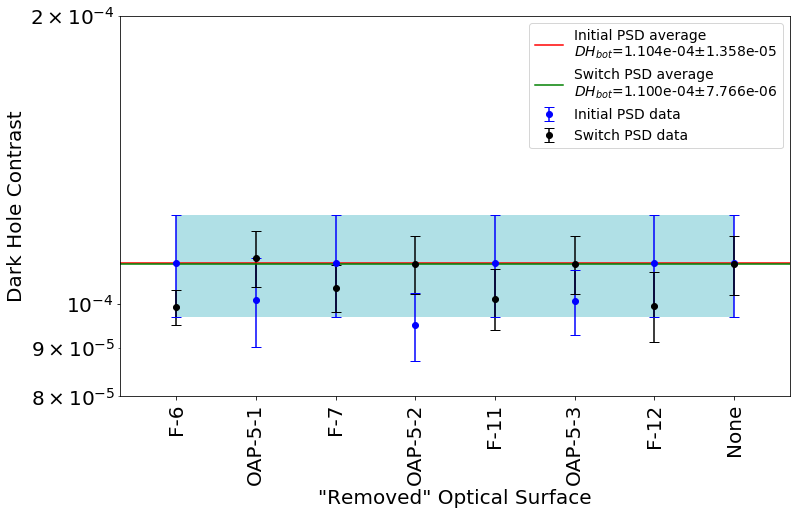

In [10]:
# Bottom DH contrast plot

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
# individual dots and error bar lines - original data
plt.errorbar(optic_name, bot_orig_avg, yerr=bot_orig_std, fmt='o', color='b',
             capsize=5, label='Initial PSD data')
# original data horz line
plt.axhline(bot_orig_avg[-1], color='r', 
            label='Initial PSD average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                        bot_orig_avg[-1],
                                                                       bot_orig_std[-1]))
# original data std dev region
plt.fill_between(np.arange(len(optic_name)),
                 bot_orig_avg[-1]+bot_orig_std[-1],
                 bot_orig_avg[-1]-bot_orig_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
# individual dots and error bar lines - original data
plt.errorbar(optic_name,bot_switch_avg, yerr=bot_switch_std, fmt='o', color='k',
             capsize=5, label='Switch PSD data')
# original data horz line
plt.axhline(bot_switch_avg[-1], color='g', 
            label='Switch PSD average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                       bot_switch_avg[-1],
                                                                      bot_switch_std[-1]))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Dark Hole Contrast')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(top=2e-4, bottom=8e-5)
plt.legend(loc='upper right', fontsize='x-small')
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.margins(0.1)
plt.show()